In [49]:
import sys
sys.path.append('../../src/')
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import collections as coll
from similarity_check.SimilarityCheck import *
#from synthetic_data_generation.generator import *
from utils import *
# Import libraries
from privacy_check.privacy_check import PrivacyCheck
from sdv.sequential.par import PARSynthesizer
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata

In [40]:
datasets = load_csvs(folder_name='./data/')

In [41]:
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["id"] = df.index
df["time"] = df["time"].apply(lambda x: x[:-6])
df.drop(["time"], inplace = True, axis = 1)

In [11]:
df.isna().sum()

generation biomass                      19
generation fossil brown coal/lignite    18
generation fossil gas                   18
id                                       0
dtype: int64

In [12]:
# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata.update_column(
    "id",
    sdtype='id',
)
metadata.set_sequence_key("id")
""" metadata.update_column(
    column_name='time',
    sdtype='datetime',
    datetime_format='%Y-%m-%d %H:%M:%S')
metadata.set_sequence_index(column_name='time') """

" metadata.update_column(\n    column_name='time',\n    sdtype='datetime',\n    datetime_format='%Y-%m-%d %H:%M:%S')\nmetadata.set_sequence_index(column_name='time') "

In [13]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "generation biomass": {
            "sdtype": "numerical"
        },
        "generation fossil brown coal/lignite": {
            "sdtype": "numerical"
        },
        "generation fossil gas": {
            "sdtype": "numerical"
        },
        "id": {
            "sdtype": "id"
        }
    },
    "sequence_key": "id"
}

# Possible methods
For the generation of synthetic datasets with time series data, we have several methods at our disposal:
- PARSynthesizer (```sdv```): Probabilistic AutoRegressive model that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.
- DoppelGANger (```gretel-synthetics```): DoppelGANger is based on a generative adversarial network (GAN) with some modifications to better fit the time series generation task.
- TimeGAN (```ydata-synthetic```): GAN based adapted to time series using a new concept: supervised loss.

### PARSynthesizer

In [20]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 10)

# Step 2: Train the synthesizer
synthesizer.fit(df)

# Step 3: Generate synthetic data. DOES NOT WORK YET - CHECK CONTEXT COLUMNS?
synthetic_data = synthesizer.sample(num_sequences=1000)

Epoch 10 | Loss 8.798675844445825e-05: 100%|██████████| 10/10 [08:54<00:00, 53.44s/it]
100%|██████████| 1000/1000 [00:00<00:00, 1011.83it/s]


In [21]:
# High number of NA values!
synthetic_data.isna().sum()

generation biomass                      528
generation fossil brown coal/lignite    438
generation fossil gas                   525
id                                        0
dtype: int64

### DoppelGANger

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [26]:
# Read smart home sensor data from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
sensor_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
sensor_df["datetime"] = pd.to_datetime(sensor_df["date"])
sensor_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,datetime
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11 17:00:00
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11 17:10:00
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11 17:20:00
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11 17:30:00
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11 17:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016-05-27 17:20:00
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016-05-27 17:30:00
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016-05-27 17:40:00
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016-05-27 17:50:00


In [27]:
# Use 4 temperature columns for this example
COLUMNS = ["T1", "T2", "T3", "T_out"]

train_df = sensor_df[["datetime"] + COLUMNS]
train_df

,datetime,T1,T2,T3,T_out
0,2016-01-11 17:00:00,19.890000,19.200000,19.790000,6.600000
1,2016-01-11 17:10:00,19.890000,19.200000,19.790000,6.483333
2,2016-01-11 17:20:00,19.890000,19.200000,19.790000,6.366667
3,2016-01-11 17:30:00,19.890000,19.200000,19.790000,6.250000
4,2016-01-11 17:40:00,19.890000,19.200000,19.790000,6.133333
...,...,...,...,...,...
19730,2016-05-27 17:20:00,25.566667,25.890000,27.200000,22.733333
19731,2016-05-27 17:30:00,25.500000,25.754000,27.133333,22.600000
19732,2016-05-27 17:40:00,25.500000,25.628571,27.050000,22.466667
19733,2016-05-27 17:50:00,25.500000,25.414000,26.890000,22.333333


In [29]:
# DGAN needs many example time series to train. Split into 1-day slices to
# create multiple examples.
features = train_df.drop(columns="datetime").to_numpy()
# Obsevations every 10 minutes, so 144 * 10 minutes = 1 day
n = features.shape[0] // 144
features = features[:(n*144),:].reshape(-1, 144, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(137, 144, 4)


In [98]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

2023-05-02 12:43:25,054 : MainThread : WARNING : There are 1 examples that have too many nan values in numeric features, accounting for 0.4807692307692308% of all examples. These invalid examples will be omitted from training.
2023-05-02 12:43:25,057 : MainThread : INFO : epoch: 0
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
2023-05-02 12:43:25,179 : MainThread : INFO : epoch: 1
2023-05-02 12:43:25,245 : MainThread : INFO : epoch: 2
2023-05-02 12:43:25,311 : MainThread : INFO : epoch: 3
2023-05-02 12:43:25,376 : MainThread : INFO : epoch: 4
2023-05-02 12:43:25,442 : MainThread : INFO : epoch: 5
2023-05-02 12:43:25,508 : MainThread : INFO : epo

In [56]:
# Setup for our dataset
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["time"] = df["time"].apply(lambda x: x[:-6])
df["time"] = pd.to_datetime(df["time"])

In [63]:
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,2015-01-01 00:00:00,447.0,329.0,4844.0
1,2015-01-01 01:00:00,449.0,328.0,5196.0
2,2015-01-01 02:00:00,448.0,323.0,4857.0
3,2015-01-01 03:00:00,438.0,254.0,4314.0
4,2015-01-01 04:00:00,428.0,187.0,4130.0
...,...,...,...,...
35059,2018-12-31 19:00:00,297.0,0.0,7634.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0


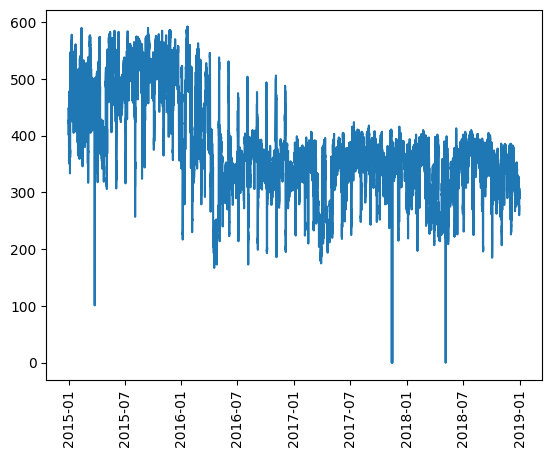

In [58]:
# We need to split our sequence into smaller mini-sequences. What length should we use?
x = df["time"]
y = df["generation biomass"]
plt.plot(x, y)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

In [99]:
# We split our data into week samples
features = df.drop(columns="time").to_numpy()
# Obsevations every hour so 7 days * 24 hours = 168 obs per mini-sequence
n_obs_per_sequence = 168
n = features.shape[0] // n_obs_per_sequence
features = features[:(n*n_obs_per_sequence),:].reshape(-1, n_obs_per_sequence, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(208, 168, 3)


In [100]:
# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=28,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=5000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

2023-05-02 12:56:18,982 : MainThread : WARNING : There are 1 examples that have too many nan values in numeric features, accounting for 0.4807692307692308% of all examples. These invalid examples will be omitted from training.
2023-05-02 12:56:18,985 : MainThread : INFO : epoch: 0
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
/opt/anaconda3/envs/CRP/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
2023-05-02 12:56:19,086 : MainThread : INFO : epoch: 1
20

In [101]:
n_samples, n_obs_per_sequence, n_features = synthetic_features.shape
print(f"We obtain a synthetic dataset with {n_samples} samples of length {n_obs_per_sequence} each for {n_features} features")

We obtain a synthetic dataset with 1000 samples of length 168 each for 3 features


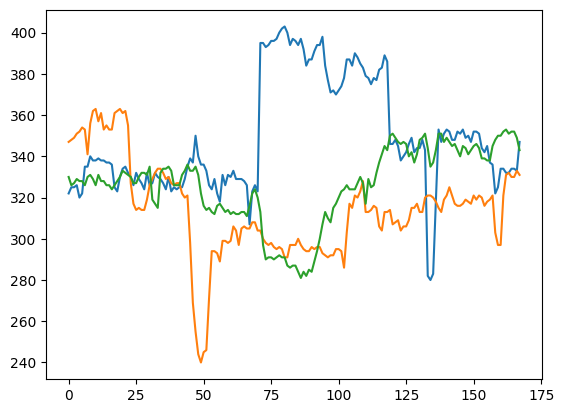

In [102]:
# Plot of original TS of one week
n_examples = 3
offset = 70
sample_example = features[offset:offset+n_examples]
biomass_original = sample_example[:, :,0]
for i in range(n_examples):
    plt.plot(biomass_original[i])
plt.show()

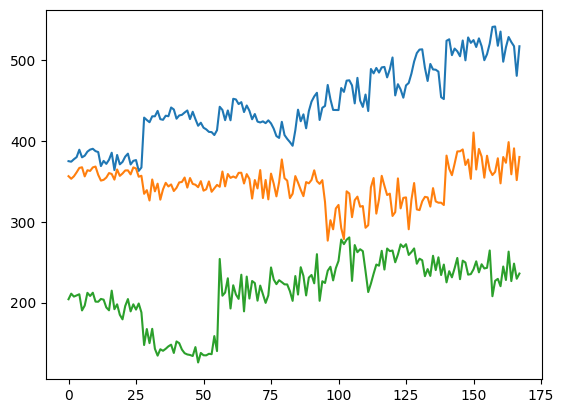

In [103]:
# Plot of synthetic TS of one week
n_examples = 3
sample_example = synthetic_features[0:n_examples]
biomass_example = sample_example[:, :,0]
for i in range(n_examples):
    plt.plot(biomass_example[i])
plt.show()